# 一. 感知机(Perceptron)

感知机由Frank Roseblatt于1957年提出，是一种广为使用的线性分类模型。感知机是最简单的神经网络，只有1个神经元。感知机是对生物神经元的简单数学模拟，有与生物神经相对应的部件，如权重（突触）、偏置（阈值）及激活函数（细胞体），输出为+1或-1.
感知机是二分类线性模型，对应于输入空间中将实例划分为正负两类的分离超平面，属于判别模型。感知机学习旨在求出将训练数据进行线性划分的分离超平面。为此，基于误分类的损失函数，利用梯度下降法对损失函数进行极小化，求得感知机模型。

## 1. 模型

定义2.1 （感知机） 假设输入空间是$\mathbf{X} \subseteq \mathbb{R^n}$，输出控件是$\mathbf{Y}=\{+1,-1\}$。输入$x\in \mathbf{X}$表示实例的特征向量，对应于输入空间的点；输出$y\in \mathbf{Y}$表示实例的类别。由输入空间到输出空间的如下函数
$$
f(x)=\mathrm{sign} (\omega\cdot x+b)
$$
称为感知机。其中，$\omega$和$b$为感知机模型参数，$\omega\in\mathbb{R^n}$为权重值或者权值向量，$b\in\mathbb{R}$称为偏置。$sign$是符号函数，即
$$
\begin{equation}
\mathrm{sign}(x)=\begin{cases}
+1,x\geq 0 \\
-1,x<0
\end{cases}
\end{equation}
$$
感知机的假设空间是定义在特征空间上的所有线性分类模型或线性分类器，即函数集合$\{f|f(x)=\omega\cdot x + b\}$

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import torch

定义感知机函数

In [230]:
def percetron(w, X, b):
    '''
    w: 参数向量 n, 1
    X: 矩阵 m, n
    b: 偏置，标量
    '''
    z = X@w + b
    y = torch.ones_like(z)
    y[torch.lt(z, 0)] = -1  # 小于0的值为-1，大于等于0的值为1
    return y

生产示例数据集

In [4]:
x0 = torch.randn(100, 2) + 2  # 均值为 2
y0 = torch.ones(100)
x1 = torch.randn(100, 2) - 2  # 均值为 -2
y1 = -torch.ones(100)

x = torch.cat((x0, x1)).type(torch.FloatTensor)
y = torch.cat((y0, y1)).type(torch.LongTensor)

In [5]:
idx = np.arange(len(x))
np.random.shuffle(idx)  # 随机打乱索引次序
train_x, train_y = x[idx[:50]], y[idx[:50]]  # 随机选取50个
test_x, test_y = x[idx[50:]], y[idx[50:]]

In [6]:
x_list = [train_x, test_x]
y_list = [train_y, test_y]

绘图

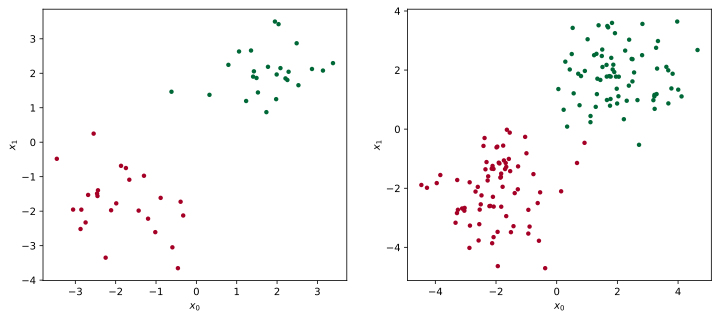

In [7]:
display.set_matplotlib_formats('svg')
fig = plt.figure(figsize=(12, 5))
for i in range(2):
    px = x_list[i]
    py = y_list[i]
    ax = fig.add_subplot(1, 2, i+1)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.scatter(px.data.numpy()[:,0], px.data.numpy()[:,1], c=py.data.numpy(), s=20, lw=0, cmap='RdYlGn')

## 2. 学习策略

### 2.1 数据集的线性可分性

定义2.2 （数据集的线性可分性）给定一个数据集
$$
T=\{(x_1,y_1),(x_2,y_2),...,(x_N,y_N)\}
$$
其中，$x_i\in \mathbf{X}=\mathrm{R^n},y_i\in\mathrm{Y}=\{+1,-1\},i=1,2,...,N$，如果存在某个超平面S
$$
\omega\cdot x + b=0
$$
能够将数据集的正实例点和负实例点完全正确地划分到超平面的两侧，即对所有的$y_i=+1$的实例i，有$\omega\cdot x_i+b>0$，对所有的$y_i=-1$的实例i，有$\omega\cdot x_i+b<0$，则称数据集$T$为线性可分数据集；否则，称之为线性不可分。

### 2.2 感知机学习策略

假设训练数据集是线性可分的，感知机学习的目标是求得一个能够将训练集正负实例完全正确分开的分离超平面。

损失函数：误分类点到超平面S的总距离。

输入空间$\mathrm{R^n}$中任意点$x_0$到超平面S的距离
$$
\mathrm{dist(x_0,S)}=\frac{1}{\|\omega\|}|\omega\cdot x_0+b|
$$
这里，$\|\omega\|$是$\omega$的$L_2$范数。

对于误分类数据点$(x_i,y_i)$，有$-y_i(\omega\cdot x_i+b)>0$成立。因此
$$
\mathrm{dist(x_0,S)}=-\frac{1}{\|\omega\|}y_i(\omega\cdot x_0+b)
$$

假定S的误分类集合为M，则素有误分类点到超平面的距离总和为
$$
\mathrm{Dist(M,S)}=-\frac{1}{\|\omega\|}\sum_{x_i\in M}y_i(\omega\cdot x_i+b)
$$
如果不考虑$\frac{1}{\|\omega\|}$，就得到了感知机学习的损失函数。
$$
L(\omega,b)=-\sum_{x_i\in M}y_i(\omega\cdot x_i+b)
$$
显然，以上损失函数是非负的，如果没有误分类点，则损失函数为0.

In [8]:
def loss(w, b, X, y):  # 所有误分类点的误差
    '''
    w: 参数向量 n, 1
    X: 矩阵 m, n
    y: 向量 m, 1
    b: 偏置，标量
    '''
    hat_y = X@w + b
    neg_Dist = -hat_y.reshape(1, -1) * y.reshape(1, -1)  # 误分类点对应的值为正
    return torch.sum(torch.relu(neg_Dist))  # relu取所有正值

### 2.3 参数学习

感知机的学习问题即$L(\omega, b)$的极小化问题

$$
\min_{\omega, b}L(\omega, b)=-\sum_{x_i\in M}y_i(\omega\cdot x_i + b)
$$

感知机是误分类驱动的，具体可采用不同的方法，如梯度下降法、随机梯度下降法等。

假设误分类集合M是固定的，那么损失函数$L(\omega, b)$的梯度由
$$
\bigtriangledown_{\omega}=-\sum_{x_i\in M}y_ix_i \\
\bigtriangledown_{\omega}=-\sum_{x_i\in M}y_i
$$
给出。

随机选取一个误分类点$(x_i,y_i)\in M$，对$\omega, b$进行更新：

$$
\omega := \omega + \eta y_i x_i \\
b := b + \eta y_i
$$

其中$0<\eta\leq 1$是步长，也称为学习率。通过迭代可以减少损失函数$L(\omega, b)$的值，直到为0.

>算法2.1  (感知机学习算法的原始形式)
>
>输入：训练数据集$T=\{(x_1,y_1),(x_2,y_2),...,(x_N,y_N)\}$，其中$x_i\in \mathbf{X=R^n}, y_i\in Y=\{-1, +1\}, i=1,2,...,N$; 学习率$\eta(0<\eta\leq 1)$；
>
>输出：$\omega,b$; 感知机模型$f(x)=\mathrm{sign}(\omega\cdot x+b)$
>
>算法过程：
>
>(1) 选取初值$\omega_0, b_0$;
>
>(2) 对于$i\in T$，根据$y_i(\omega\cdot x_i+b)\leq 0$获取误分类点集合M
>
>(3) 在M中随机选取数据$(x_i, y_i)$;
>
>(3) 如果$(y_i(\omega\cdot x_i+b))\leq 0$,
$$
\omega := \omega + \eta y_i x_i \\
b := b + \eta y_i
$$
>(4) 若$M=\emptyset$，则结束算法；否则，转至(2)

In [68]:
def learning_model_sgd(X, y, epochs=100, lr=0.03):
    '''
    X: 特征矩阵
    y: 标签
    epochs: 最大训练批次
    lr: 学习率
    '''
    w = torch.randn(size=(X.shape[1], 1))
    b = torch.zeros(size=(1, ))
    s_idx = np.arange(X.shape[0])  # 训练样本的下标
    for epoch in range(epochs):
        np.random.shuffle(s_idx)  # 随机打乱s_idx
        for i in s_idx:  #
            x_i = X[i]
            y_i = y[i]
            if (x_i @ w + b) * y_i <= 0: # 选择第一个分错的点更新
                w = w + (lr*y_i*x_i).reshape(-1, 1)
                b = b + lr*y_i
                break  # 更新一个误分类点后跳出循环，进行下一轮
        else:  # 如果所有节点被正确分类，则跳出迭代
            print(f'迭代在{epoch+1}次结束, 所有数据点已被正确分类!')
            break
    return w, b

In [69]:
w, b = learning_model_sgd(train_x, train_y)

迭代在24次结束, 所有数据点已被正确分类!


- 采用梯度下降法进行训练
>利用所有误分类点计算损失函数

In [9]:
def learning_model(lossfunc, X, y, epochs=50, lr=0.03):
    '''
    lossfunc: 损失函数
    X: 特征矩阵
    y: 标签
    epochs: 训练批次
    lr: 学习率
    '''
    w = torch.randn(size=(X.shape[1], 1), requires_grad=True)
    b = torch.zeros(size=(1, ), requires_grad=True)
    for epoch in range(epochs):
        l = lossfunc(w, b, X, y)
        l.backward()
        w.data.sub_(lr*w.grad)
        w.grad.data.zero_()
        b.data.sub_(lr*b.grad)
        b.grad.data.zero_()
        with torch.no_grad():  # 不计算梯度，加速损失函数的运算
            d_w, d_b = w.detach(), b.detach()
            train_l = loss(d_w, d_b, X, y)  # 最近一次的负对数似然率
            if epoch % 5 == 0:
                print(f'epoch {epoch}, loss: {train_l.numpy():.4f}')
    return w, b

In [10]:
def failure_ratio(w, b, feature, true_label):
    predict_label = percetron(w, feature, b)
    sum_mis = torch.sum(torch.relu(-true_label.reshape(1, -1) * predict_label.reshape(1, -1)))
    return sum_mis / len(true_label)

In [95]:
w, b = learning_model(loss, train_x, train_y, epochs=20)

epoch 0, loss: 0.0000
epoch 5, loss: 0.0000
epoch 10, loss: 0.0000
epoch 15, loss: 0.0000


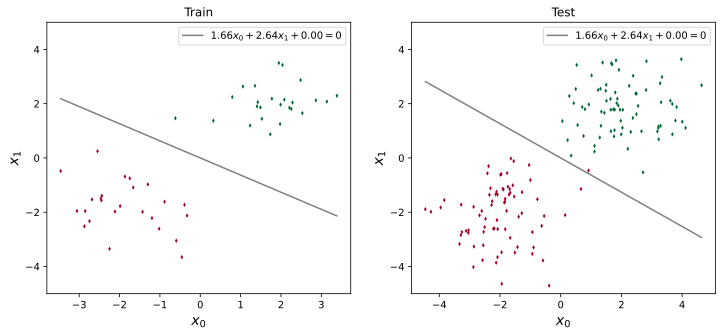

In [96]:
d_w = w.data.numpy()
d_b = b.data.numpy()
w0, w1 = d_w.reshape(1, -1)[0]
b = d_b[0]
title_list = ['Train', 'Test']

display.set_matplotlib_formats('svg')
fig = plt.figure(figsize=(12, 5))
for i in range(2):
    px = x_list[i]
    py = y_list[i]
    x0 = px.data.numpy()[:,0]
    x1 = px.data.numpy()[:,1]
    y = -(w0*x0+b) / w1  # 超平面
    ax = fig.add_subplot(1, 2, i+1)
    ax.set_title(title_list[i])
    ax.set_xlabel('$x_0$', fontsize=14)
    ax.set_ylabel('$x_1$', fontsize=14)
    ax.scatter(x0, x1, c=py.data.numpy(), s=10, lw=0, marker='d', cmap='RdYlGn')
    ax.set_ylim([-5, 5])
    ax.plot(x0, y, 'k-', alpha=0.5, label=f"${w0:.2f}x_0+{w1:.2f}x_1+{b:0.2f}=0$")
    ax.legend(loc='best')

### 感知机学习算法的对偶形式

增广参数$\hat{\omega}=(\mathbf{\omega}, b)$:
$$
\begin{aligned}
\mathbf{\hat{\omega}} &=  (\omega_1, \omega_2, ..., \omega_n, b) \\
&= (\sum_{i=1}^N \alpha_i y_i x_i^1, \sum_{i=1}^N \alpha_i y_i x_2^2, ..., \sum_{i=1}^N \alpha_i y_i x_i^n, \sum_{i=1}^N \alpha_i y_i) \\
&= (\mathbf{\alpha_{1\times N} \odot y_{1\times N}^T) X_{N\times (n+1)}}
\end{aligned}
$$
其中$\mathbf{\alpha}=(\alpha_1, \alpha_2, ..., \alpha_N)$是针对各数据点的更新累积量。例如，如果针对点0更新了4次，则对应有$\alpha_0=4\eta$，$\eta$为学习率。

感知机为
$$
f(x_i) = \mathbf{\hat{\omega}\hat{x_i}^T}
$$
其中$\mathbf{\hat{x_i}}=(x_i^1, x_i^2, ..., x_i^n, 1)$。

可以先计算$\mathbf{A} = \hat{X}_{N\times (n+1)} \hat{X}_{(n+1)\times N}^T$，迭代更新遇到误分类点$x_i$时，直接取对应的列$A_{.,i}$，即计算$(\mathbf{\alpha_{1\times N} \odot y_{1\times N}^T) A_{.,i}}$。由于$X$和$y$是已知的，因此只需更新$\alpha$即可。

>算法2.2 （感知机学习算法的对偶形式）
>输入：训练数据集$T=\{(x_1,y_1),(x_2,y_2),...,(x_N,y_N)\}$，其中$x_i\in \mathbf{X=R^n}, y_i\in Y=\{-1, +1\}, i=1,2,...,N$; 学习率$\eta(0<\eta\leq 1)$；
>
>输出：$\mathbf{\alpha},b$, 其中$\mathbf{\alpha}=(\alpha_1,\alpha_2,...,\alpha_N)^T$为各数据点更新的次数; 感知机模型$f(x)=\mathrm{sign}(\sum_{j=1}^N \alpha_jy_j\cdot \mathbf{x} +b)$
>
>算法过程：
>
>(1) $\alpha := (0, 0, ..., 0)^T$, b:= 0;
>
>(2) 在训练集T中根据$y_i\left(\sum_{j=1}^N\alpha_j y_j x_j\cdot x_i+b\right)\leq 0$随机选取一个误分类数据$(x_i,y_i)$;
>
>(3) 执行更新$\alpha_i:=\alpha_i+\eta,b:=b+\eta y_i$;
>
>(4) 转至(2)直到没有误分类点

如果数据点维度n很大，且数据集样本数量N较小，则由于只需计算一次$XX^T$，更新过程只需记录$\omega, b$的更新过程，可降低计算复杂度。

In [209]:
def learning_model_dual_sgd(X, y, epochs=100, lr=0.03):
    '''
    X: 特征矩阵 N*n
    y: 标签
    epochs: 最大训练批次
    lr: 学习率
    '''
    gram = X @ X.t()  # 求X的Gram矩阵 (N, N)
    alpha = torch.zeros(X.shape[0])  # 误分类的更新累积量
    b = torch.zeros(1)
    s_idx = np.arange(X.shape[0])  # 训练样本的下标
    for epoch in range(epochs):
        np.random.shuffle(s_idx)  # 随机打乱s_idx
        for i in s_idx:
            if (alpha * train_y @ gram[i] + b) * y[i] <= 0: # 选择第一个分错的点更新
                alpha[i] = alpha[i] + lr
                b = b + lr * y[i]
                break  # 更新一个误分类点后跳出循环，进行下一轮
        else:  # 如果所有节点被正确分类，则跳出迭代
            print(f'迭代在{epoch+1}次结束, 所有数据点已被正确分类!')
            break
            
    w = train_y * alpha @ train_x  # 对应的w
    return w, b, alpha

In [210]:
w, b, alpha = learning_model_dual_sgd(train_x, train_y, epochs=100, lr=0.01)

迭代在2次结束, 所有数据点已被正确分类!


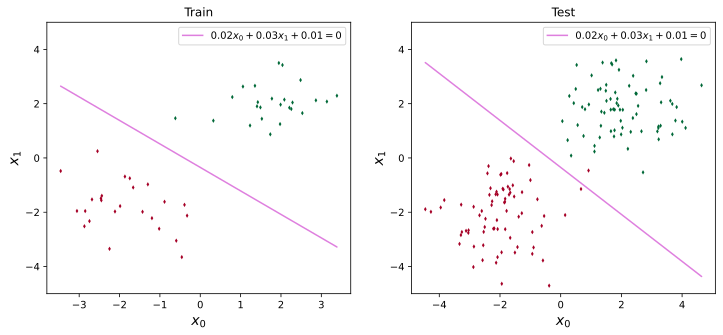

In [211]:
d_w = w.data.numpy()
d_b = b.data.numpy()
w0, w1 = d_w.reshape(1, -1)[0]
b = d_b[0]
title_list = ['Train', 'Test']

display.set_matplotlib_formats('svg')
fig = plt.figure(figsize=(12, 5))
for i in range(2):
    px = x_list[i]
    py = y_list[i]
    x0 = px.data.numpy()[:,0]
    x1 = px.data.numpy()[:,1]
    y = -(w0*x0+b) / w1  # 超平面
    ax = fig.add_subplot(1, 2, i+1)
    ax.set_title(title_list[i])
    ax.set_xlabel('$x_0$', fontsize=14)
    ax.set_ylabel('$x_1$', fontsize=14)
    ax.scatter(x0, x1, c=py.data.numpy(), s=10, lw=0, marker='d', cmap='RdYlGn')
    ax.set_ylim([-5, 5])
    ax.plot(x0, y, 'm-', alpha=0.5, label=f"${w0:.2f}x_0+{w1:.2f}x_1+{b:0.2f}=0$")
    ax.legend(loc='best')